### CS 178: Machine Learning &amp; Data Mining

# Discussion 07

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons

from sklearn.datasets import fetch_openml            # common data set access
from sklearn.preprocessing import StandardScaler     # scaling transform
from sklearn.model_selection import train_test_split # validation tools
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import zero_one_loss as J01

import sklearn.tree
from sklearn.tree import DecisionTreeClassifier

# Fix the random seed for reproducibility
# !! Important !! : do not change this
seed = 1234
np.random.seed(seed)  

# Decision Trees

Let's start with a simple toy data set, and see how to build and examine our decision tree models:

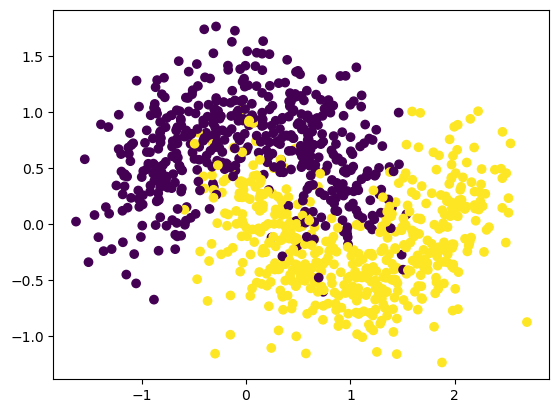

In [4]:
# Creating 2-moons dataset
n_samples = 1000
noise = 0.3
X, Y = make_moons(n_samples, noise=noise)

fig, axes = plt.subplots()
axes.scatter(X[:,0], X[:,1], c=Y);

### Fitting a decision tree

We can train a decision tree using either entropy or gini (default) impurity scores, and control the complexity of the learned tree in a number of ways.  The most basic is to provide a maximum depth:

In [10]:
learner = DecisionTreeClassifier(max_depth = 1, criterion='entropy', random_state = seed)
learner.fit(X,Y);

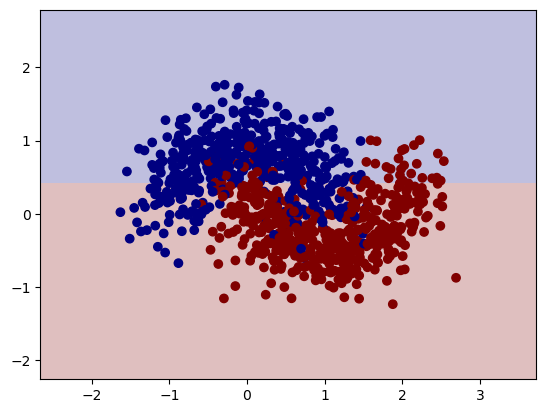

Error rate: 0.189


In [12]:
plot_kwargs = {'cmap':'jet', 
               'response_method':'predict', 
               'plot_method':'pcolormesh', 
               'shading':'auto', 
               'alpha':0.25,
               'grid_resolution':100 }

DecisionBoundaryDisplay.from_estimator(learner, X, **plot_kwargs)
plt.scatter(X[:,0],X[:,1], c=Y, cmap='jet');
plt.show()
print(f'Error rate: {np.round(J01(learner.predict(X),Y),4)}')

We can see that the first split is reasonable; it gets about 80% of the data correct, and splits along feature $x_2$ to divide the space in two.  If we allow a bit more depth, our learner can be more complex:

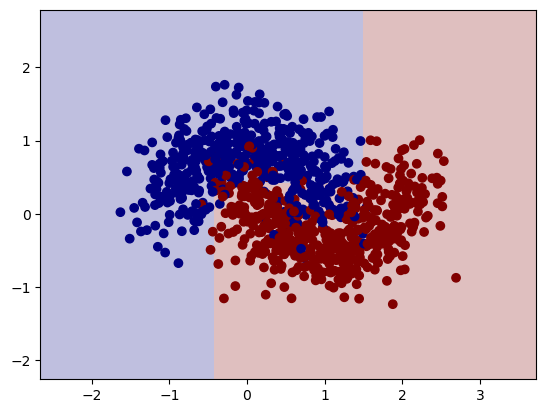

Error rate: 0.104


In [15]:
learner = DecisionTreeClassifier(max_depth = 2, criterion='entropy', random_state = seed)
learner.fit(X,Y);

DecisionBoundaryDisplay.from_estimator(learner, X, **plot_kwargs)
plt.scatter(X[:,0],X[:,1], c=Y, cmap='jet');
plt.show()
print(f'Error rate: {np.round(J01(learner.predict(X),Y),4)}')

We can visualize the tree that has been fit (if it is simple enough):

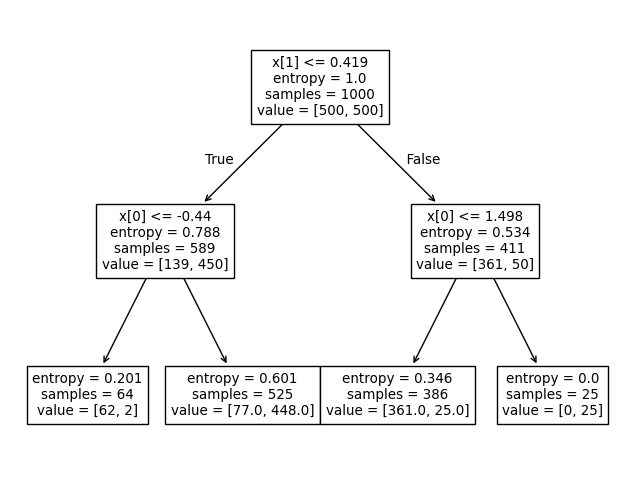

In [17]:
plt.figure(figsize=(8,6))
sklearn.tree.plot_tree(learner);

The more complexity we allow, the better our (training) performance, but the harder the tree is to interpret:

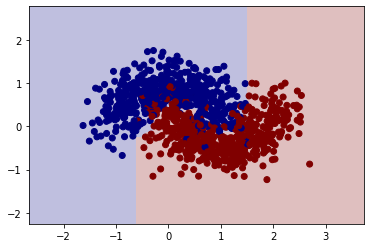

Error rate: 0.038


In [7]:
learner = DecisionTreeClassifier(max_depth = 8, criterion='entropy', random_state = seed)
learner.fit(X,Y);

DecisionBoundaryDisplay.from_estimator(learner, X, **plot_kwargs)
plt.scatter(X[:,0],X[:,1], c=Y, cmap='jet');
plt.show()
print(f'Error rate: {np.round(J01(learner.predict(X),Y),4)}')

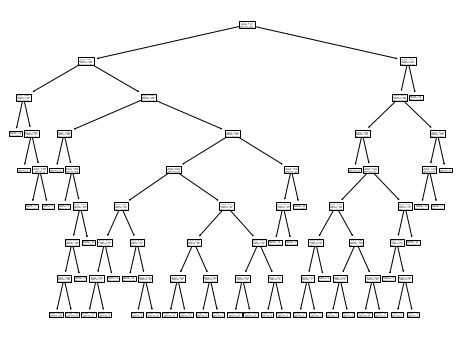

In [8]:
plt.figure(figsize=(8,6))
sklearn.tree.plot_tree(learner);

## More complexity controls

Depth is a crude way to control the complexity of the model.  Another useful technique is the minimum number of data required to define a node.  In scikit, this is the ``min_samples_leaf`` argument:

In [19]:
np.random.seed(seed)
XB = np.vstack((3*np.random.rand(50,2)-1.5,np.random.randn(50,2)))
YB = np.vstack((np.zeros((50,1)),np.ones((50,1)))).squeeze()

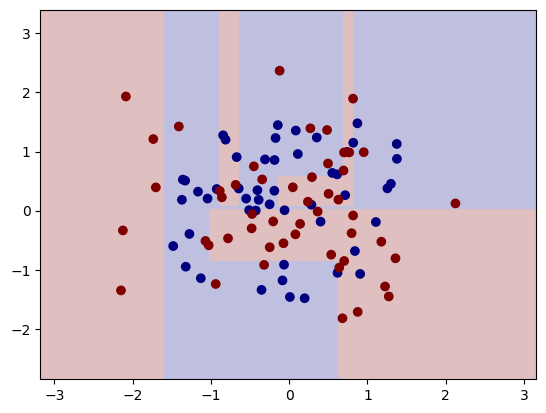

Error rate: 0.2


In [21]:
learner = DecisionTreeClassifier(max_depth = 20, criterion='entropy', min_samples_leaf=5, random_state = seed)
learner.fit(XB,YB);

DecisionBoundaryDisplay.from_estimator(learner, XB, **plot_kwargs)
plt.scatter(XB[:,0],XB[:,1], c=YB, cmap='jet');
plt.show()
print(f'Error rate: {np.round(J01(learner.predict(XB),YB),4)}')

## Expressing uncertainty in our predictions

We do not need to output a "hard decision" always; we can instead output an estimated probability of each class (a "soft decision"), which in the case of leaf nodes that are not all one class or the other, can express the mix of classes in the training data at that point of the tree:

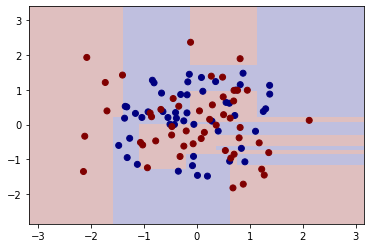

Error rate: 0.12


In [11]:
# Hard decisions:
learner = DecisionTreeClassifier(max_depth = 8, criterion='entropy', random_state = seed)
learner.fit(XB,YB);

DecisionBoundaryDisplay.from_estimator(learner, XB, **plot_kwargs)
plt.scatter(XB[:,0],XB[:,1], c=YB, cmap='jet');
plt.show()
print(f'Error rate: {np.round(J01(learner.predict(XB),YB),4)}')

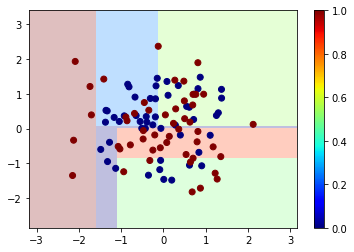

Error rate: 0.29


In [13]:
# Soft decisions (use "predict_proba")
learner = DecisionTreeClassifier(max_depth = 4, criterion='entropy', random_state = seed)
learner.fit(XB,YB);

plot_soft = {'cmap':'jet', 
               'response_method':'predict_proba', 
               'plot_method':'pcolormesh', 
               'shading':'auto', 
               'alpha':0.25,
               'grid_resolution':100 }

DecisionBoundaryDisplay.from_estimator(learner, XB, **plot_soft)
plt.scatter(XB[:,0],XB[:,1], c=YB, cmap='jet');
plt.colorbar()
plt.show()
print(f'Error rate: {np.round(J01(learner.predict(XB),YB),4)}')

We can see that regions that are "pure" (all red, or all blue) are predicted confidently, while more "mixed" regions are predicted to be somewhere in the middle.

----
# Ensemble Methods & Trees

## Bagging: Bootstrap Estimation

Bootstrap is a technique for evaluating the variability of an estimator or learner by comparing its value under different random re-samplings of the data set.  Let's make a tiny dataset to start:

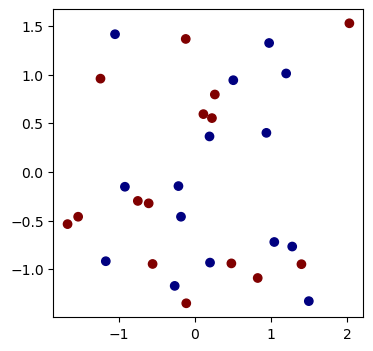

In [23]:
np.random.seed(seed+10)
m=30
XB = np.vstack((3*np.random.rand(m//2,2)-1.5,np.random.randn(m//2,2)))
YB = np.vstack((np.zeros((m//2,1)),np.ones((m//2,1)))).squeeze()

plt.figure(figsize=(4,4))
plt.scatter(XB[:,0],XB[:,1], c=YB, cmap='jet');
ax = plt.axis()
plt.show()

Now, we can re-sample with replacement by generating (uniform) random indices for each bootstrap sample.  If we look at the indices we select each time, they are different, with some data points left out and others repeated:

[ 1  3  3  4  5  5  5  7  7 10 12 12 13 13 13 16 16 18 19 20 24 24 24 25
 25 26 27 28 29 29]
[ 3  3  5  5  7  8  8  8  9 10 10 12 12 14 14 16 17 17 18 20 21 24 24 25
 26 27 28 28 29 29]
[ 1  3  3  4  4  5  5  6  7  7  8  9 10 11 12 15 15 15 16 17 19 19 20 20
 20 22 23 27 27 28]
[ 0  0  1  2  3  4  6  6  8  9  9  9 14 15 16 17 18 18 19 20 21 21 22 24
 25 25 27 27 29 29]
[ 0  0  0  1  1  2  4  6  7  8 10 13 13 15 16 17 17 19 21 22 22 22 23 24
 25 25 28 29 29 29]


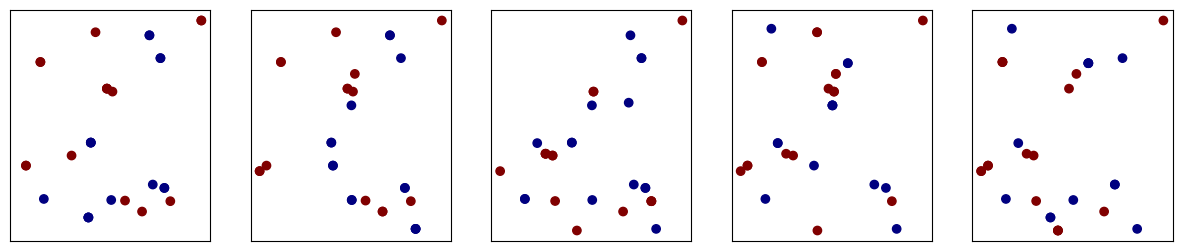

In [25]:
np.random.seed(seed+10)
fig,axes = plt.subplots(1,5,figsize=(15,3))
for b in range(5):
    index = (np.random.rand(m)*m).astype(int)
    axes[b].scatter(XB[index,0],XB[index,1],c=YB[index],cmap='jet')
    axes[b].axis(ax)
    axes[b].set_xticks([]); axes[b].set_yticks([])
    print(np.sort(index))

Fitting our learner on each bootstrap sample gives us a sense of how much variance is in our learner:

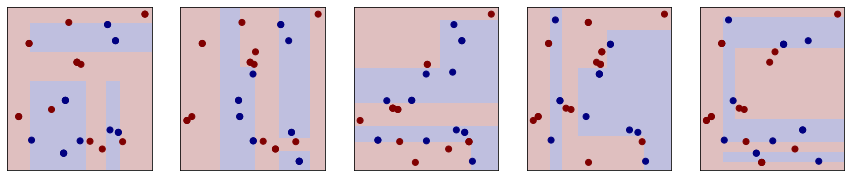

In [38]:
np.random.seed(seed+10)
fig,axes = plt.subplots(1,5,figsize=(15,3))
learner = DecisionTreeClassifier(max_depth = 8, criterion='entropy', random_state = seed)
for b in range(5):
    index = (np.random.rand(m)*m).astype(int)
    learner.fit(XB[index,:],YB[index]);
    DecisionBoundaryDisplay.from_estimator(learner, XB[index,:], ax=axes[b], **plot_kwargs)
    axes[b].scatter(XB[index,0],XB[index,1], c=YB[index], cmap='jet')
    #axes[b].scatter(XB[index,0],XB[index,1],c=YB[index],cmap='jet')
    axes[b].axis(ax)
    axes[b].set_xticks([]); axes[b].set_yticks([])

These learners can be used to estimate the variance, or, in the case of bagging, as ensemble members.

## Boosting: AdaBoost

Adaboost is a boosting algorithm that operates on any learner that can classify a (weighted) set of labelled examples.  It operates by re-weighting the data at each step, to emphasize incorrectly classified data examples when learning the next classifier in the ensemble.

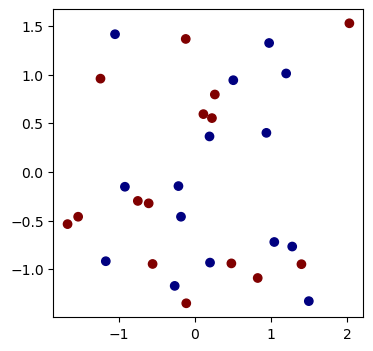

In [27]:
np.random.seed(seed+10)
m=30
XB = np.vstack((3*np.random.rand(m//2,2)-1.5,np.random.randn(m//2,2)))
YB = np.vstack((np.zeros((m//2,1)),np.ones((m//2,1)))).squeeze()

plt.figure(figsize=(4,4))
plt.scatter(XB[:,0],XB[:,1], c=YB, cmap='jet');
ax = plt.axis()
plt.show()

In [39]:
from sklearn.ensemble import AdaBoostClassifier

In [60]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=10)
ada.fit(XB,YB);

We can look at the learners that we have found:

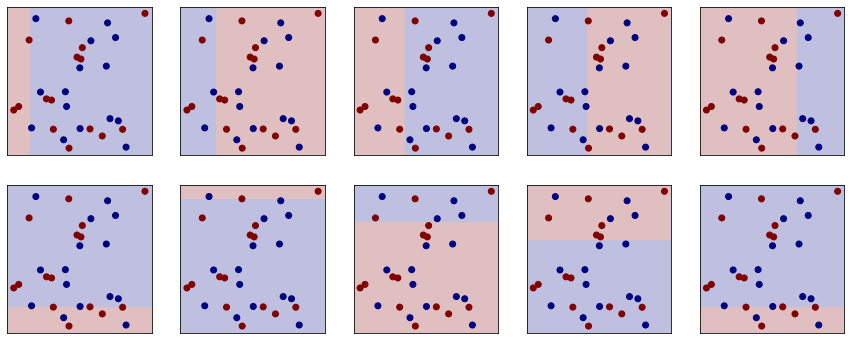

In [50]:
fig,axes = plt.subplots(2,5,figsize=(15,6))
for b in range(10):
    DecisionBoundaryDisplay.from_estimator(ada.estimators_[b], XB, ax=axes[b//5,b%5], **plot_kwargs)
    axes[b//5,b%5].scatter(XB[:,0],XB[:,1], c=YB, cmap='jet')
    axes[b//5,b%5].axis(ax)
    axes[b//5,b%5].set_xticks([]); axes[b//5,b%5].set_yticks([])

The overall ensemble is defined by the (weighted) vote of these members; their relative coefficients alpha are determined as part of the ensemble learning process:

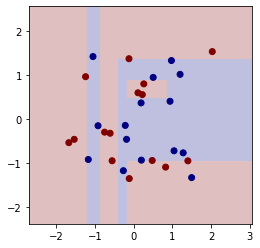

In [59]:
fig,axes = plt.subplots(1,1,figsize=(4,4))
DecisionBoundaryDisplay.from_estimator(ada, XB, ax=axes, **plot_kwargs)
plt.scatter(XB[:,0],XB[:,1], c=YB, cmap='jet');